In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # multilayer perceptron for regression
import pandas as pd
from sklearn.preprocessing import StandardScaler



In [2]:
def direct_kin_(joints, links, origin=[0, 0]):
    """
    Implement the forward kinematics for a two-joint planar manipulator.
    Args:
        joints (list): A list of two joint angles in radians, representing the configuration of the manipulator.
        links (list): A list of two link lengths representing the lengths of the two links of the manipulator.
        origin (list, optional): An optional parameter that represents the origin point (default [0,0]) from which
        the forward kinematics are calculated.

    Returns:
        list: A list of two arrays [X, Y] representing the Cartesian coordinates of all the link endpoints.
    """
    X = np.zeros(3)
    Y = np.zeros(3)
    X[0] = origin[0]
    Y[0] = origin[1]
    X[1] = X[0] + links[0] * np.cos(joints[0])
    Y[1] = Y[0] + links[0] * np.sin(joints[0])
    X[2] = X[1] + links[1] * np.cos(joints[0] + joints[1])
    Y[2] = Y[1] + links[1] * np.sin(joints[0] + joints[1])
    return [X, Y]  # return the coordinates of all link endpoints


def deg2rad(degrees):
    """
    Convert degrees to radians.

    Args:
        degrees (float): A value in degrees to be converted to radians.

    Returns:
        float: The value converted to radians.
    """
    return degrees * np.pi / 180


# Define a function to update the data frame
def update_dataframe(df, network, learning_rate, algorithm, n_data_set, n_test_data_set, joint_range_x, joint_range_y,
                     max_iteration, activation, solver, accuracy, test_accuracy, error, end_effector_position):
    """
    Update the data frame with a new row of data.
    """
    new_row = pd.DataFrame({'Network Layers': [network],
                            'Learning Rate': [learning_rate],
                            'Algorithm': [algorithm],
                            'Number of Dataset': [n_data_set],
                            'Number of Test Data': [n_test_data_set],
                            'Joint range X': [joint_range_x],
                            'Joint range Y': [joint_range_y],
                            'Max Iteration': [max_iteration],
                            'Activation': [activation],
                            'Solver': [solver],
                            'Accuracy': [accuracy],
                            'Test Accuracy': [test_accuracy],
                            'Error': [error],
                            'Actual End-effector Position': [end_effector_position]
                            })
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [3]:
class Arm:
    def __init__(self, links=[10, 10], origin=[0, 0], init=[0, 0]):
        """
        Class constructor, defining the basic attributes of the arm and initial configuration.

        Args:
            links (list, optional): An optional parameter that represents the lengths of the two links of the arm (default [10, 10]).
            origin (list, optional): An optional parameter that represents the origin point (default [0, 0]) from which the arm is positioned.
            init (list, optional): An optional parameter that represents the initial joint angles (default [0, 0]).
        """
        self.link1 = links[0]
        self.link2 = links[1]
        self.x0 = origin[0]
        self.y0 = origin[1]
        self.joint1 = init[0]
        self.joint2 = init[1]
        self.direct_kin()  # Call the direct_kin() method to perform forward kinematics calculation

    def direct_kin(self):
        """
        Calculate the Cartesian coordinates for the current joint configuration.
        """
        # Call the direct_kin_() function with the current joint angles, link lengths, and origin coordinates
        [self.X, self.Y] = direct_kin_([self.joint1, self.joint2], [self.link1, self.link2], [self.x0, self.y0])

    def plot_arm(self):
        """
        Generate a 2D plot of the current arm configuration.
        """
        # Plot the baseline
        plt.plot([-20, 20], [0, 0], 'k')

        # Plot the arm segments
        plt.plot(self.X, self.Y, linewidth=2.0)

        # Plot the arm segment endpoints as red circles
        plt.plot(self.X, self.Y, 'ro', linewidth=2.0)

        # Set the x and y axis limits based on the total length of the arm
        sum_links = (self.link1 + self.link2) * 1.1
        plt.axis([-sum_links, sum_links, -1, sum_links])

        # Set equal scaling for x and y axes
        plt.axis('equal')

        # Show the plot
        plt.show()

    def change_joint_origin(self, new_origin_x, new_origin_y):
        # Prompt user for new arm origin
        print("Current arm origin: ", self.joint1, " ", self.joint2)
        self.joint1 = new_origin_x
        self.joint2 = new_origin_y
        print("Arm joint1 changed to: ", self.joint1, self.joint2)
        self.direct_kin()

    def change_arm_origin(self, new_origin_x, new_origin_y):
        # Prompt user for new arm origin
        print("Current arm origin: ", self.x0, " ", self.y0)
        self.x0 = new_origin_x
        self.y0 = new_origin_y
        print("Arm origin changed to: ", self.x0, self.y0)
        self.direct_kin()

    def create_data(self, ann, n_train, n_test, range1, range2):
        """
        Prepare the training and test sets for the neural network solver.

        Parameters:
            - ann: Neural network solver (e.g., an instance of a neural network class)
            - n_train: Number of training samples
            - n_test: Number of test samples
            - range1: Range for joint 1 values (e.g., [min_joint1, max_joint1])
            - range2: Range for joint 2 values (e.g., [min_joint2, max_joint2])
        """
        self.inv_solver = ann  # Store the neural network solver in the class attribute
        n_data = n_train + n_test  # Total number of data points
        joint_space = np.hstack((np.random.uniform(range1[0], range1[1], size=(n_data, 1)),
                                 np.random.uniform(range2[0], range2[1],
                                                   size=(n_data, 1))))  # Generate random joint configurations
        cartesian_space = np.zeros(np.shape(joint_space))  # Initialize array for storing Cartesian coordinates
        for i in range(len(joint_space)):
            ax, ay = direct_kin_(joint_space[i], [self.link1,
                                                  self.link2])  # Calculate Cartesian coordinates for each joint configuration
            cartesian_space[i] = [ax[2], ay[2]]  # Store the Cartesian coordinates
        self.cart_train = np.asarray(cartesian_space[:n_train, :])  # Store the training Cartesian coordinates
        self.joint_train = np.asarray(joint_space[:n_train, :])  # Store the training joint configurations
        self.cart_test = np.asarray(cartesian_space[n_train:, :])  # Store the test Cartesian coordinates
        self.joint_test = np.asarray(joint_space[n_train:, :])  # Store the test joint configurations

    def train_inv_kin(self):
        """
        Train the kinematic solver.

        Returns:
            - Training accuracy (mean of scores from the solver)
        """
        self.inv_solver.fit(self.cart_train, self.joint_train)  # Fit the neural network solver with the training data
        score = self.inv_solver.score(self.cart_train, self.joint_train)  # Calculate training accuracy
        return np.mean(score)  # Return the mean of the training accuracy

    def test_inv_kin(self):
        """
        Test the kinematic solver.

        Returns:
            - Testing accuracy (mean of scores from the solver)
        """
        score = self.inv_solver.score(self.cart_test, self.joint_test)  # Calculate testing accuracy
        return np.mean(score)  # Return the mean of the testing accuracy

    def inv_kin(self, Cartesian):
        """
        Query the trained inverse kinematic solver on a single Cartesian target.

        Args:
            - Cartesian: Cartesian target position

        Returns:
            - err: Euclidean distance error between the predicted and actual end-effector position
            - [self.X[2], self.Y[2]]: Actual end-effector position
        """
        joints = self.inv_solver.predict([Cartesian])  # Predict joint configurations for given Cartesian target
        [self.joint1, self.joint2] = joints[0]  # Update joint angles
        self.direct_kin()  # Update Cartesian coordinates of the end-effector
        err = np.sqrt((Cartesian[0] - self.X[2]) ** 2 + (Cartesian[1] - self.Y[2]) ** 2)  # Calculate error
        return err, [self.X[2], self.Y[2]]  # Return error and actual end-effector position

The average training accuracy for the dataset:  0.9411519697975842
The average testing accuracy:  0.9532209074740432


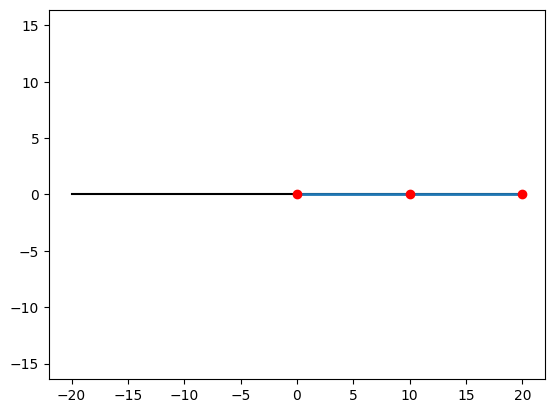

In [4]:
# this code is only an example, remove it or change it

a = Arm()

ann = MLPRegressor()

n_train = 1000
n_test = 100

j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)

a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
a.plot_arm()



In [5]:
# Define a Cartesian target position
cartesian_target = [1.5, 2.0]  # target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)

# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)

Error: 1.6411648650546853
Actual End-effector Position: [0.7209014363200392, 3.4444471407295545]


In [6]:

df = pd.DataFrame({'Network Layers': [(100,)],
                   'Learning Rate': ['constant'],
                   'Algorithm': ['MLP'],
                   'Number of Dataset': [n_train],
                   'Number of Test Data': [n_test],
                   'Joint range X': [j1_range],
                   'Joint range Y': [j2_range],
                   'Max Iteration': [0],
                   'Activation': ['relu'],
                   'Solver': ['adam'],
                   'Accuracy': [accuracy],
                   'Test Accuracy': [test_accuracy],
                   'Error': [err],
                   'Actual End-effector Position': [actual_end_effector_position]
                   })

# Display the original data frame
print("Original Data Frame:")
print(df)

Original Data Frame:
  Network Layers Learning Rate Algorithm  Number of Dataset   
0         (100,)      constant       MLP               1000  \

   Number of Test Data            Joint range X           Joint range Y   
0                  100  (0, 1.5707963267948966)  (0, 3.141592653589793)  \

   Max Iteration Activation Solver  Accuracy  Test Accuracy     Error   
0              0       relu   adam  0.941152       0.953221  1.641165  \

               Actual End-effector Position  
0  [0.7209014363200392, 3.4444471407295545]  


Task 1 : change the network structure (number of layers and neurons), and parameters (transfer functions, learning rate, algorithms, stop conditions): how does prediction accuracy change?


A. Change the network structure(number of layer and neurons) and parameters(transfer functions, learning rate, algorithms, stop conditions)

In [7]:
# Example
hidden_layers = (50,)
max_iter = 200
activation_func = "identity"
solver_algo = "adam"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6938946265447189
The average testing accuracy:  0.6876622782047749
Error: 4.697355613756596
Actual End-effector Position: [-1.6069276142473683, 5.523088213757607]


In [8]:
#  Example
hidden_layers = (200,)
max_iter = 300
activation_func = "logistic"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9530280434292508
The average testing accuracy:  0.9372695688576425
Error: 3.0347052788158315
Actual End-effector Position: [0.09759119731659105, -0.6912238255910197]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# Example
hidden_layers = (100,50)
max_iter = 400
activation_func = "tanh"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9856015782882406
The average testing accuracy:  0.9909463559345881
Error: 0.7809828551563536
Actual End-effector Position: [0.9028603696853104, 1.4966527223121142]


In [10]:
# Fourth Example
hidden_layers = (200,100)
max_iter = 500
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6923097438302472
The average testing accuracy:  0.699665387884783
Error: 4.710461416600299
Actual End-effector Position: [-1.823169692222823, 5.33841129191293]


In [11]:
# Example
hidden_layers = (150,60)
max_iter = 350
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6626880653776714
The average testing accuracy:  0.6870480101206852
Error: 6.159228812544288
Actual End-effector Position: [-2.5257347504048964, 6.661497536699783]


In [12]:
# Example
hidden_layers = (300,450)
max_iter = 600
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6936499660349085
The average testing accuracy:  0.6662662431757403
Error: 4.754976632401359
Actual End-effector Position: [-1.7519614085339175, 5.469084860894739]


In [13]:
# Eight Example
hidden_layers = (600,300)
max_iter = 600
activation_func = "tanh"
solver_algo = "sgd"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.22843807701495894
The average testing accuracy:  0.13688702528410435
Error: 16.19606265249986
Actual End-effector Position: [15.601527218132054, 9.966139313367657]


In [14]:
# Nine Example
hidden_layers = (320,460)
max_iter = 450
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "constant"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.686100872078656
The average testing accuracy:  0.6832252868035891
Error: 5.729579640322799
Actual End-effector Position: [-1.9325165136831703, 6.587582504772407]


In [17]:
# Tenth Example
hidden_layers = (200,200,200)
max_iter = 400
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 100
j1_range = (0, np.pi / 2)
j2_range = (0, np.pi)
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.4572783745658694
The average testing accuracy:  0.49002079367577533
Error: 10.38216607916477
Actual End-effector Position: [-3.277702703024465, 11.21753380123297]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


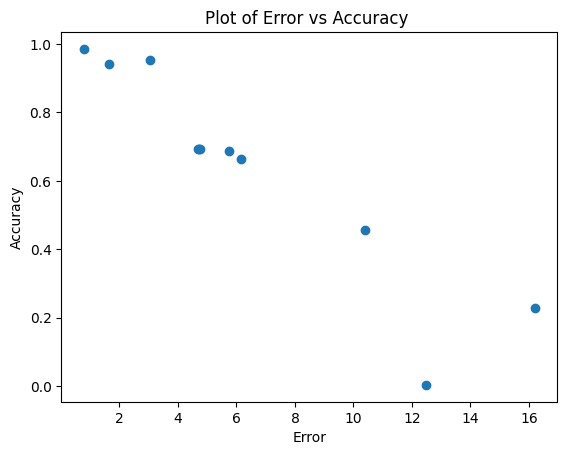

In [22]:
x = df['Error']
y = df['Accuracy']

plt.scatter(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Plot of Error vs Accuracy ')
plt.show()

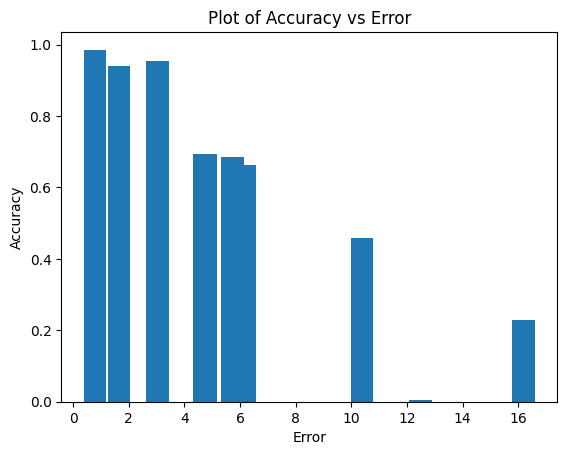

In [23]:
x = df['Error']
y = df['Accuracy']

plt.bar(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Error')
plt.show()

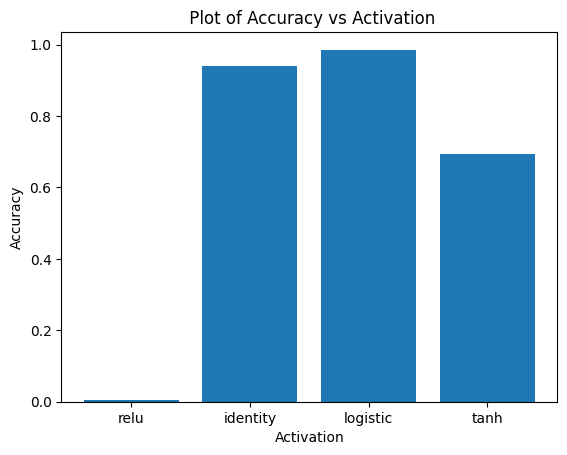

In [24]:
x = df['Activation']
y = df['Accuracy']

plt.bar(x,np.sort(y))
plt.xlabel('Activation')
plt.ylabel('Accuracy')
plt.title(' Plot of Accuracy vs Activation')
plt.show()

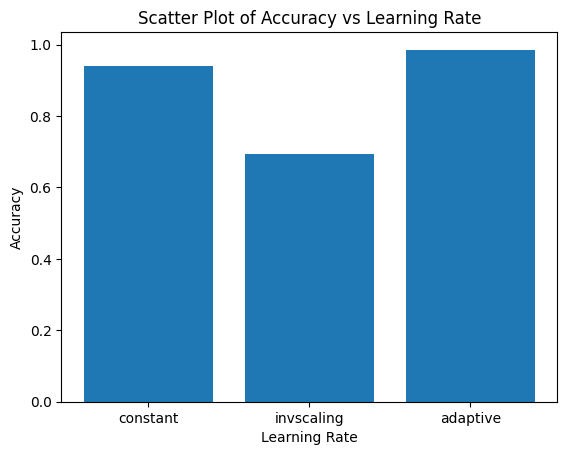

In [25]:
x = df['Learning Rate']
y = df['Accuracy']

plt.bar(x, y)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Learning Rate')
plt.show()

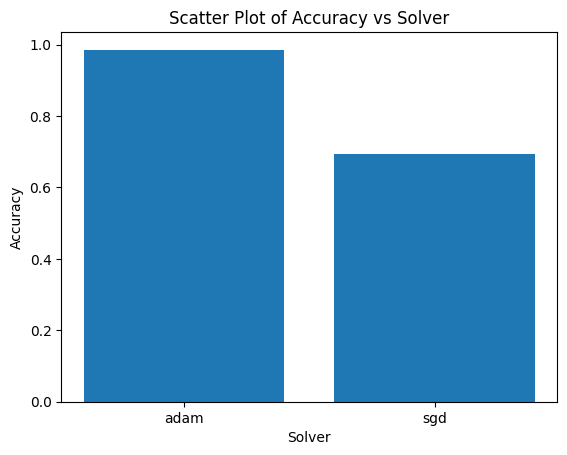

In [26]:
x = df['Solver']
y = df['Accuracy']

plt.bar(x, y)
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Solver')
plt.show()

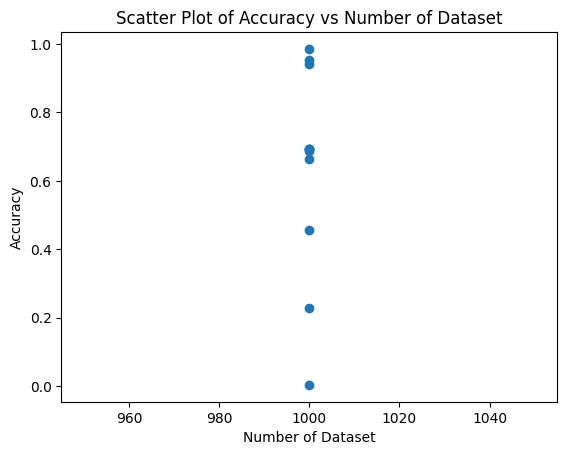

In [27]:
x = df['Number of Dataset']
y = df['Accuracy']

plt.scatter(x, y)
plt.xlabel('Number of Dataset')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy vs Number of Dataset')
plt.show()

B.Change the quantity of training data, and the joint ranges: how does that affect accuracy?


In [28]:
# Example
hidden_layers = (50,)
max_iter = 200
activation_func = "identity"
solver_algo = "adam"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1200
n_test = 110
j1_range = (0, deg2rad(30))
j2_range = (0, deg2rad(45))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.4886078296240016
The average testing accuracy:  0.47179716097381047
Error: 19.715093004543395
Actual End-effector Position: [17.830657744839115, -9.045112484656826]


In [29]:
# First Example
hidden_layers = (200,)
max_iter = 300
activation_func = "logistic"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 2000
n_test = 200
j1_range = (0, deg2rad(45))
j2_range = (0, deg2rad(60))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9468599428751967
The average testing accuracy:  0.9492984963502185
Error: 20.960751194541913
Actual End-effector Position: [-10.860431991559032, -14.928461584607572]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
# First Example
hidden_layers = (100,50)
max_iter = 400
activation_func = "tanh"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 3000
n_test = 300
j1_range = (0, deg2rad(60))
j2_range = (0, deg2rad(70))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9625754083245015
The average testing accuracy:  0.9635631454149725
Error: 7.326942385624862
Actual End-effector Position: [-4.8172248356800935, -1.7117051469281286]


In [31]:
# Example
hidden_layers = (50,50)
max_iter = 400
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 1000
n_test = 300
j1_range = (0, deg2rad(35))
j2_range = (0, deg2rad(90))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6826036228657895
The average testing accuracy:  0.6747111658647845
Error: 11.571258018511987
Actual End-effector Position: [12.365694271241676, 5.978781237374555]


In [32]:
# Example
hidden_layers = (150,60)
max_iter = 350
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 5000
n_test = 500
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(120))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6668642496863251
The average testing accuracy:  0.660910737970979
Error: 8.102583276401875
Actual End-effector Position: [0.10224891262151736, 9.98111193059962]


In [33]:
# First Example
hidden_layers = (300,450)
max_iter = 600
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 6000
n_test = 600
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(120))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6578539708015385
The average testing accuracy:  0.6586691850150458
Error: 7.907257196327908
Actual End-effector Position: [0.4586312927600513, 9.838384245778009]


In [34]:
# First Example
hidden_layers = (600,300)
max_iter = 600
activation_func = "tanh"
solver_algo = "sgd"
learning_rate = "invscaling"
stop_condition = False

ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 7000
n_test = 700
j1_range = (0, deg2rad(120))
j2_range = (0, deg2rad(150))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.8295905777345701
The average testing accuracy:  0.8267749539848865
Error: 15.147715732407873
Actual End-effector Position: [15.99688304427436, 6.392456477925253]


In [35]:
# First Example
hidden_layers = (50,)
max_iter = 450
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "constant"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 5000
n_test = 100
j1_range = (0, deg2rad(30))
j2_range = (0, deg2rad(60))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.6754926043643597
The average testing accuracy:  0.6593777100157212
Error: 8.395393914709402
Actual End-effector Position: [9.578841374520444, 4.28362891654408]


/Users/toluwanimi/PycharmProjects/final-course-work/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
# First Example
hidden_layers = (200,200,200)
max_iter = 400
activation_func = "logistic"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 10000
n_test = 1000
j1_range = (0, deg2rad(60))
j2_range = (0, deg2rad(90))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.49641382993179456
The average testing accuracy:  0.4963997641944848
Error: 15.478248121726079
Actual End-effector Position: [8.571889774764237, 15.768243894240904]


In [37]:
# First Example
hidden_layers = (150,250,100)
max_iter = 250
activation_func = "logistic"
solver_algo = "adam"
learning_rate = "invscaling"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 20000
n_test = 2500
j1_range = (0, deg2rad(60))
j2_range = (0, deg2rad(90))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9832447237085292
The average testing accuracy:  0.9830121867801569
Error: 9.289873928293803
Actual End-effector Position: [5.1598123083443195, 10.538590719274719]


In [38]:
# First Example
hidden_layers = (100,50)
max_iter = 300
activation_func = "tanh"
solver_algo = "adam"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 3500
n_test = 3000
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9866963535801075
The average testing accuracy:  0.9838524152396897
Error: 1.2487212138419919
Actual End-effector Position: [0.7052629884854573, 1.0368293233139045]


In [39]:
# First Example
hidden_layers = (50,50,50)
max_iter = 400
activation_func = "relu"
solver_algo = "sgd"
learning_rate = "constant"
stop_condition = True
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 12000
n_test = 1200
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9869182193778979
The average testing accuracy:  0.9887288833132837
Error: 1.08423153876204
Actual End-effector Position: [0.46429691814434904, 1.6792553104398953]


In [40]:
# First Example
hidden_layers = (120,350,200)
max_iter = 300
activation_func = "relu"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False
ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 2030
n_test = 350
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.9569250909370427
The average testing accuracy:  0.9430746794879028
Error: 1.5441145010095614
Actual End-effector Position: [-0.031424477740333856, 1.802443270917562]


In [41]:
# First Example
hidden_layers = (200,100)
max_iter = 500
activation_func = "identity"
solver_algo = "sgd"
learning_rate = "adaptive"
stop_condition = False

ann = MLPRegressor(hidden_layer_sizes=hidden_layers,
                   max_iter=max_iter,
                   activation=activation_func,
                   solver=solver_algo,
                   learning_rate=learning_rate,
                   early_stopping=stop_condition)
n_train = 2000
n_test = 300
j1_range = (0, deg2rad(90))
j2_range = (0, deg2rad(180))
a.create_data(ann, n_train, n_test, j1_range, j2_range)
accuracy = a.train_inv_kin()
test_accuracy = a.test_inv_kin()
print("The average training accuracy for the dataset: ", accuracy)
print("The average testing accuracy: ", test_accuracy)
cartesian_target = [1.5, 2.0]  #  target position

# Call the inv_kin() function with the Cartesian target position
err, actual_end_effector_position = a.inv_kin(cartesian_target)
# Print the calculated error and actual end-effector position
print("Error:", err)
print("Actual End-effector Position:", actual_end_effector_position)
df = update_dataframe(df, hidden_layers, learning_rate, 'MLP', n_train, n_test, j1_range,
                      j2_range,
                      max_iter, activation_func, solver_algo, accuracy, test_accuracy, err,
                      actual_end_effector_position)

The average training accuracy for the dataset:  0.7064130171969554
The average testing accuracy:  0.6960427716289941
Error: 4.768553765284213
Actual End-effector Position: [-1.7679993533712732, 5.472648159369328]


In [42]:
print(df.shape)

(25, 14)


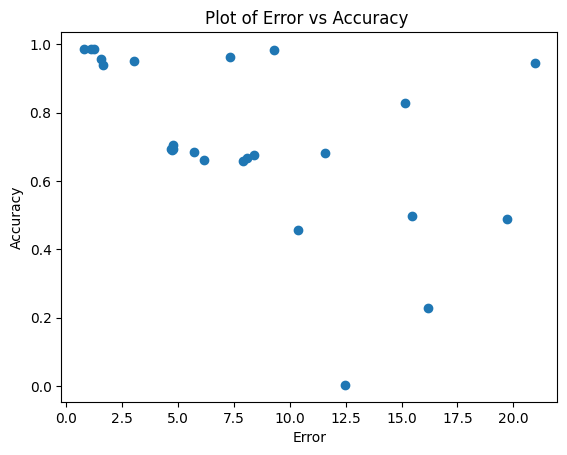

In [44]:
x = df['Error']
y = df['Accuracy']

plt.scatter(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Plot of Error vs Accuracy ')
plt.show()

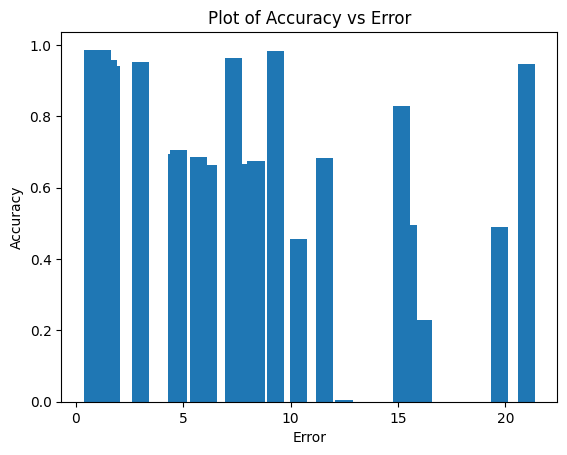

In [45]:
x = df['Error']
y = df['Accuracy']

plt.bar(x, y)
plt.xlabel('Error')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Error')
plt.show()

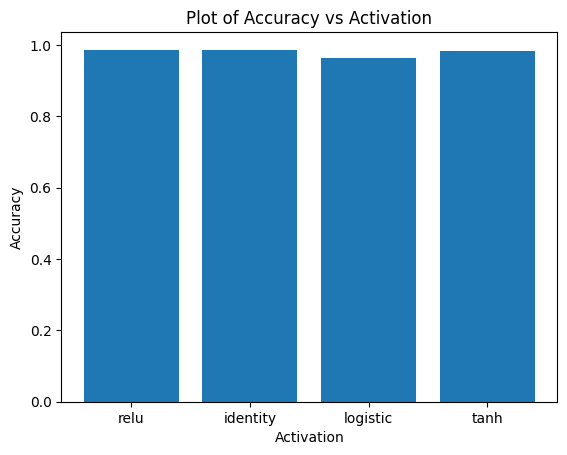

In [47]:
x = df['Activation']
y = df['Accuracy']

plt.bar(x,np.sort(y))
plt.xlabel('Activation')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Activation')
plt.show()

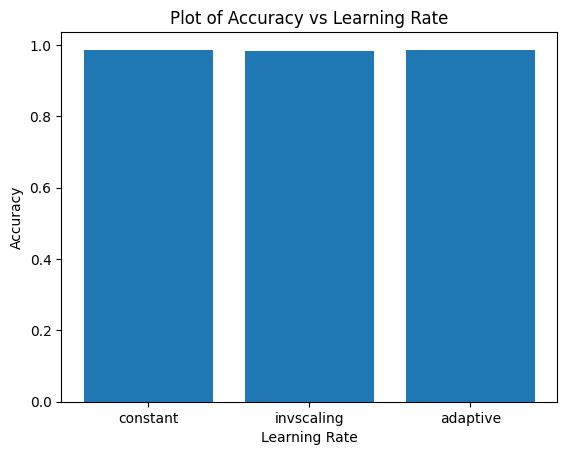

In [50]:
x = df['Learning Rate']
y = df['Accuracy']

plt.bar(x, y)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Learning Rate')
plt.show()

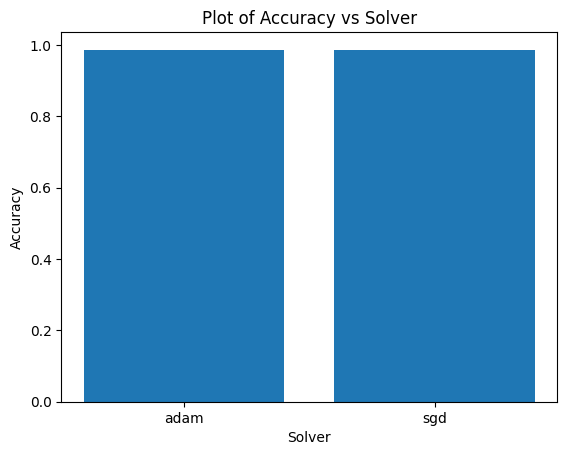

In [52]:
x = df['Solver']
y = df['Accuracy']

plt.bar(x, y)
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Solver')
plt.show()

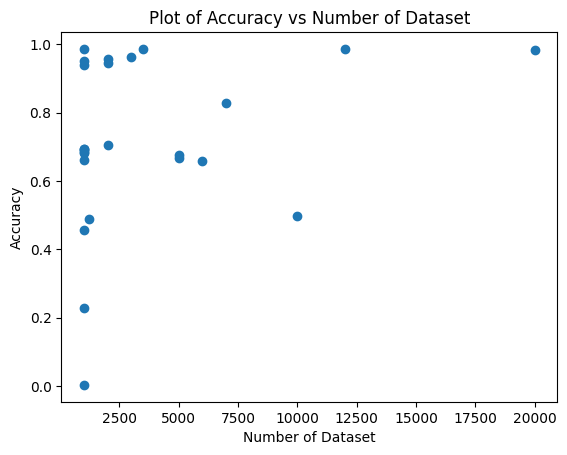

In [53]:
x = df['Number of Dataset']
y = df['Accuracy']

plt.scatter(x, y)
plt.xlabel('Number of Dataset')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracy vs Number of Dataset')
plt.show()

In [54]:
print(df.describe())

       Number of Dataset  Number of Test Data  Max Iteration   Accuracy   
count          25.000000            25.000000      25.000000  25.000000  \
mean         3629.200000           490.400000     386.000000   0.720985   
std          4548.505176           745.606465     142.536545   0.250693   
min          1000.000000           100.000000       0.000000   0.003436   
25%          1000.000000           100.000000     300.000000   0.662688   
50%          1200.000000           110.000000     400.000000   0.693650   
75%          5000.000000           500.000000     450.000000   0.953028   
max         20000.000000          3000.000000     600.000000   0.986918   

       Test Accuracy      Error  
count      25.000000  25.000000  
mean        0.715536   8.124468  
std         0.258351   5.857295  
min        -0.000034   0.780983  
25%         0.659378   4.697356  
50%         0.687662   7.326942  
75%         0.949298  11.571258  
max         0.990946  20.960751  


In [55]:
# Extract the 'Accuracy' column
accuracy = df['Accuracy']

# Convert the 'Accuracy' column to a numpy array
accuracy_array = np.array(accuracy)

# Calculate the root mean square of accuracy
rms_accuracy = np.sqrt(np.mean(accuracy_array**2))

print('Root Mean Square of Accuracy:', rms_accuracy)

Root Mean Square of Accuracy: 0.7616779393450441


In [56]:
# Extract the 'Accuracy' column
accuracy = df['Test Accuracy']

# Convert the 'Accuracy' column to a numpy array
accuracy_array = np.array(accuracy)

# Calculate the root mean square of accuracy
rms_accuracy = np.sqrt(np.mean(accuracy_array**2))

print('Root Mean Square of Test Accuracy:', rms_accuracy)

Root Mean Square of Test Accuracy: 0.758990530232909


A. change the network structure (number of layers and neurons), and parameters (transfer functions, learning rate, algorithms, stop conditions): how does prediction accuracy change?


Scatter Plot of Accuracy vs Activation

Based on the chart, it appears that the logistic activation function outperforms the other three functions (identity, tanh, and relu) in terms of accuracy. The logistic function has a smooth and bounded output, which can help prevent the gradient from vanishing or exploding during training. However, the logistic function also has a limited range, which can make it harder for the network to model complex data.
The identity function comes next, The tanh function is similar to the logistic function, but with a wider range, which can help the network better model complex data. However, like the logistic function, it can also suffer from vanishing gradients.
Even though relu function (rectified linear unit) has become a popular choice in recent years due to its simplicity and computational efficiency, it has performed low compared to the other functions. It also helps prevent vanishing gradients but can suffer from "dead" neurons that output zero for all inputs less than zero.


Scatter Plot of Accuracy vs Learning Rate

Based on the chart, adaptive learning rate schedule outperforms the other two schedules that was considered in this analysis (constant and inverse scaling) in terms of the accuracy.
Adaptive learning rate schedules, such as Adam or Adagrad, dynamically adjust the learning rate based on the gradient history of the network during training. This can lead to faster convergence and better performance compared to fixed learning rate schedules.
Constant learning rate was right behind adaptive learning rate, constant learning rate schedules keep the learning rate fixed throughout training. While this can work well in some cases, it can also lead to suboptimal performance if the learning rate is not set properly.
Inverse scaling schedules decrease the learning rate over time as the number of epochs increases. This can help the network converge more slowly and avoid overshooting the minimum of the loss function. However, this schedule can also lead to slower convergence and may not perform as well as adaptive learning rate schedules in certain cases. This attribute is seen through the chart as Inverse scaling performs least in the learning rates considered.


Scatter Plot of Accuracy vs Solver

Based on the chart, the Adam optimization algorithm outperforms the Stochastic Gradient Descent (SGD) algorithm in terms of Accuracy.

Adam is an adaptive optimization algorithm that combines the benefits of two other optimization algorithms, Adagrad and RMSprop. It uses adaptive learning rates for each parameter and momentum-like techniques to overcome the limitations of SGD.
On the other hand, SGD is a simple and widely used optimization algorithm that updates the parameters of the network using the gradients of the loss function with respect to the parameters. While it is computationally efficient and easy to implement, SGD can converge slowly and may get stuck in local optima.


B. change the quantity of training data, and the joint ranges: how does that affect accuracy?

Perform systematic tests on appropriate values and ranges (how do you choose them?) and report your results, answering the questions.

 The graph shows a high instability in accuracy (ranging between 0.1 and 1) with low number of datasets, but as the data set increases, the accuracy began to tend towards 1 more having little or no sample of training below 0.5 and later a guaranteed accuracy of almost 100%